# Introduction
* In this notebook, I will explor PyStan package.[Reference](https://pystan.readthedocs.io/en/latest/getting_started.html)
* There are two main sections here:
    * Explore the mechanism behind PyStan.
    * Explore the "Eight School" example to understand the bayesian analysis more.

In [1]:
import pystan
import scipy
import arviz
import chart_studio.plotly  as py
import plotly.express as px
import plotly.graph_objs as go
import psutil

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# II. Explore the mechanism behind **PyStan**
Create two samples (gamma distribution) and use PyStan to see fitting results

### The sample data (visiting time of two groups)

In [2]:
# Create two samples (gamma distribution) and use PyStan to see fitting results
# Assume this is an AB test experiment (Landing-page visiting time)

size = 250
shape_list = [0.85, 1]  # k  (alpha)
scale_general = 10  # theta   (beta = 1 / theta)

control = np.random.gamma(shape=shape_list[0], scale=scale_general, size=size)
experimental = np.random.gamma(shape=shape_list[1], scale=scale_general, size=size)

In [3]:
# control group data - first 20
print('The first 20 data of control group: ')
print(control[:20])
print('\n')
print('The first 20 data of experimental group: ')
print(experimental[:20])

The first 20 data of control group: 
[1.37282727e+01 4.56638783e+00 1.36345921e+01 7.97591161e-01
 1.64816756e+01 2.70512222e+01 5.35075819e+00 4.52568317e-04
 4.95123617e+00 6.87291512e+00 2.45577419e+00 1.55530823e+01
 2.25886537e+00 1.66332046e+00 9.85777464e+00 1.42323748e+00
 8.98180306e+00 1.03496770e+01 2.03561115e+01 7.58135439e+00]


The first 20 data of experimental group: 
[1.36278154e+01 4.82663774e+00 5.97196066e+00 1.62716927e+01
 1.38718288e+01 4.51190117e+01 1.48150756e+01 4.27911306e+00
 1.70864617e+00 1.78102311e+01 7.44271213e+00 9.34305745e-01
 9.98876536e+00 8.61422764e-01 8.94373283e+00 2.93387212e+01
 2.39221751e+00 3.36686503e-01 2.39034257e-02 4.25848724e+00]


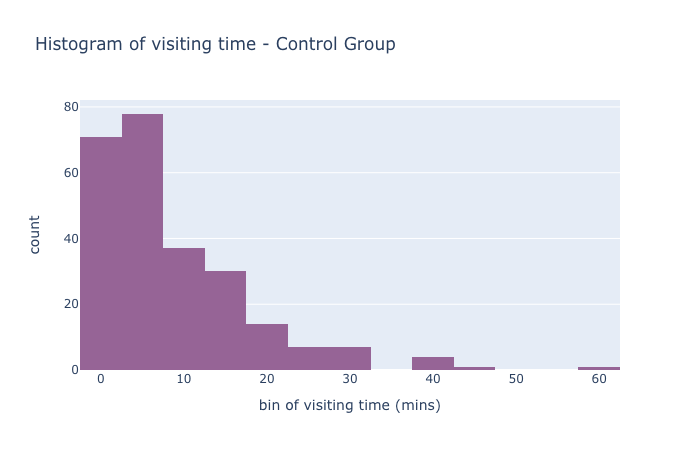

In [4]:
# Control Group
fig = px.histogram(x=control, labels={"x":"bin of visiting time (mins)"}, 
                   title='Histogram of visiting time - Control Group',
                  nbins=25, color_discrete_sequence=['rgb(150,100,150)'])
fig.show("png")

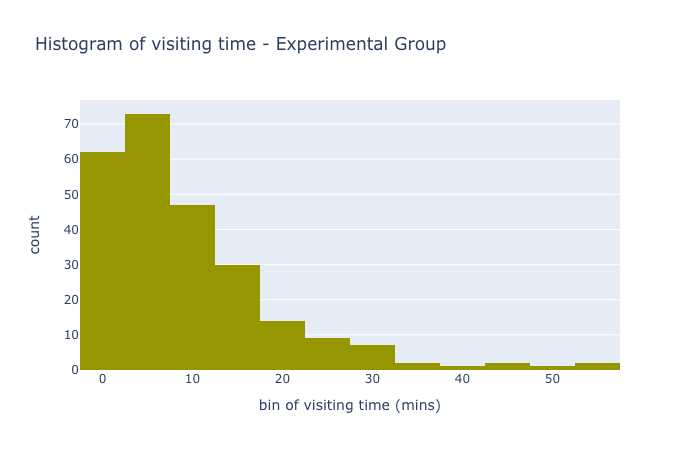

In [5]:
# Experimental Group
fig = px.histogram(x=experimental, labels={"x":"bin of visiting time (mins)"}, 
                   title='Histogram of visiting time - Experimental Group',
                   nbins=25, color_discrete_sequence=['rgb(150,150,0)'])
fig.show("png")

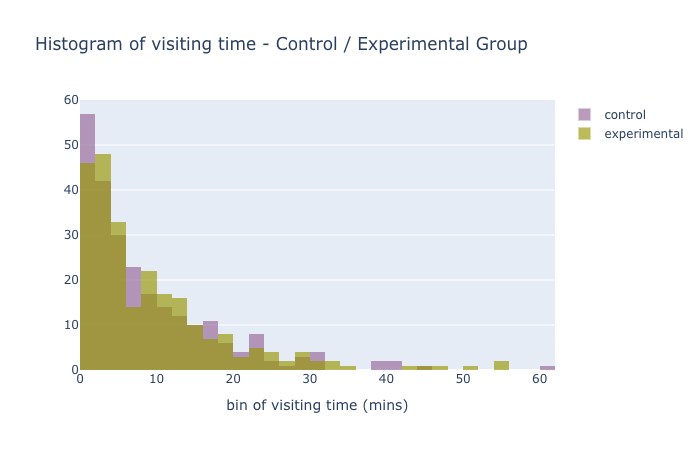

In [18]:
# Plots of two groups
fig = go.Figure()
fig.add_trace(go.Histogram(x=control, 
                           #nbinsx=25, 
                           bingroup=1, # to share the same bins
                           xbins=dict( # bins used for histogram
                                start=0,
                                #end=3.0,
                                #size=0.5
                            ),
                           name='control', 
                           marker=dict(
                                color="rgb(150,100,150)")
                            ))
fig.add_trace(go.Histogram(x=experimental, 
                           #nbinsx=25, 
                           bingroup=1, # to share the same bins
                           xbins=dict( # bins used for histogram
                                start=0,
                                #end=3.0,
                                #size=0.5
                            ),
                           name='experimental', 
                           marker=dict(
                                color="rgb(150,150,0)")
                            ))

# Overlay both histograms
fig.update_layout(barmode='overlay', title='Histogram of visiting time - Control / Experimental Group',
                 xaxis_title="bin of visiting time (mins)")

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.65)
fig.show("png")

### PyStan
Use PyStan to create and fit model (Two gamma models)

In [12]:
# Create and fit PyStan Model

control_experimental_code = """
data {
    int<lower=0> J; // length of data
    vector[J] x1; // control
    vector[J] x2; // experimental
}
parameters {
    real<lower=0> alpha1;  // shape1
    real<lower=0> alpha2;  // shape2
    real<lower=0> theta;   // 1/scale
}
model {
    x1 ~ gamma(alpha1, 1/theta);
    x2 ~ gamma(alpha2, 1/theta);
}

generated quantities {
    real d;
    
    d = alpha2 - alpha1;
}
"""

control_experimental_data = {
                'J': size,
               'x1': control,
               'x2': experimental}

sm = pystan.StanModel(model_code=control_experimental_code)
fit = sm.sampling(data=control_experimental_data, iter=3000, warmup=300, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a48382a6a3a3d78f29315ba6560c2c8a NOW.


In [13]:
# Get the fitting results
print(fit)

Inference for Stan model: anon_model_a48382a6a3a3d78f29315ba6560c2c8a.
3 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=8100.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1   0.91  9.8e-4   0.06    0.8   0.87   0.91   0.95   1.04   3827    1.0
alpha2   0.99  1.1e-3   0.06   0.86   0.94   0.99   1.03   1.11   3436    1.0
theta    9.71    0.01   0.71   8.47   9.22   9.67  10.17  11.23   3172    1.0
d        0.07  8.6e-4   0.07  -0.06   0.03   0.07   0.12    0.2   6102    1.0
lp__    -1605    0.02   1.21  -1608  -1606  -1605  -1604  -1604   3475    1.0

Samples were drawn using NUTS at Wed Mar  4 17:44:27 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
# Each posterior distribution
Alpha1 = fit.extract(permuted=True)['alpha1']
Alpha2 = fit.extract(permuted=True)['alpha2']
Theta = fit.extract(permuted=True)['theta']
D = fit.extract(permuted=True)['d']
Lp__ = fit.extract(permuted=True)['lp__']
summary = fit.summary()

In [23]:
summary

OrderedDict([('summary',
              array([[ 9.13761854e-01,  9.79606425e-04,  6.06023040e-02,
                       7.99097170e-01,  8.71301862e-01,  9.12344784e-01,
                       9.54610129e-01,  1.03580018e+00,  3.82714592e+03,
                       1.00003316e+00],
                     [ 9.86074754e-01,  1.10217987e-03,  6.46025754e-02,
                       8.62385946e-01,  9.41194868e-01,  9.85335734e-01,
                       1.02954638e+00,  1.11373186e+00,  3.43553768e+03,
                       1.00129243e+00],
                     [ 9.71450296e+00,  1.25399908e-02,  7.06219216e-01,
                       8.46737489e+00,  9.21578578e+00,  9.67125894e+00,
                       1.01675371e+01,  1.12276607e+01,  3.17164540e+03,
                       1.00031088e+00],
                     [ 7.23128997e-02,  8.57236085e-04,  6.69637957e-02,
                      -5.82867723e-02,  2.62238174e-02,  7.32243946e-02,
                       1.17462014e-01,  2.03873300e-

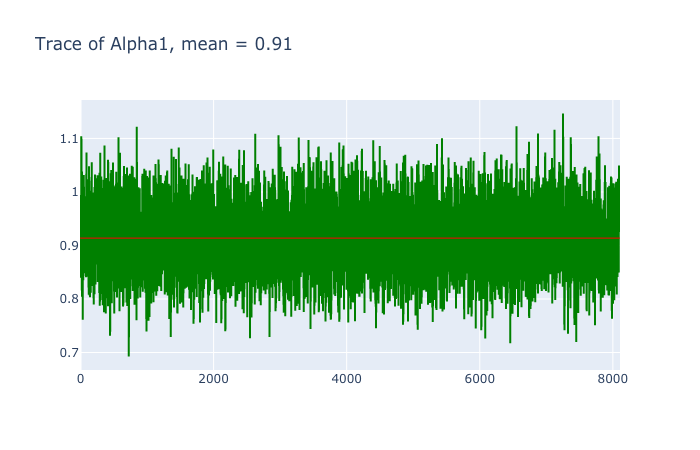

In [56]:
# Plot of Alpha1 (trace)
fig = go.Figure(
    data=[go.Scatter(y=Alpha1, marker=dict(color='green'))],
    layout_title_text=("Trace of Alpha1, mean = {:.2f}".format(Alpha1.mean()))
    
)

hline = go.layout.Shape(type="line", x0=0, y0=Alpha1.mean(), 
                        x1=8100, y1=Alpha1.mean(),
                        line=dict(color="red", width=1, dash="solid")
                       )
                       
fig.add_shape(hline)
fig.show("png")

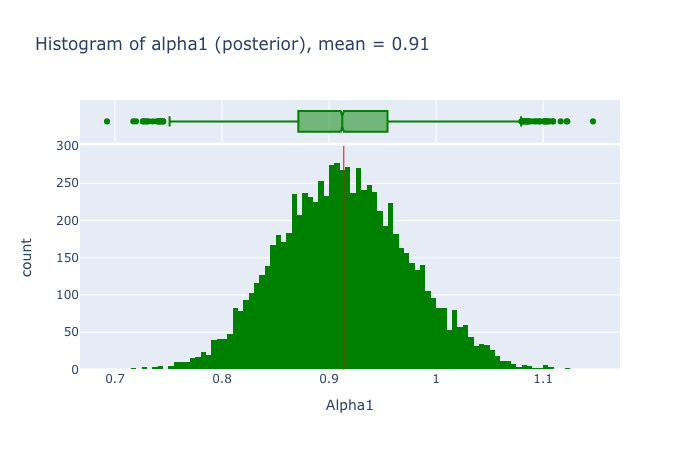

In [33]:
# Plot of Alpha1 (Distribution)
fig = px.histogram(x=Alpha1, labels={"x":"Alpha1"}, marginal='box',
                   title='Histogram of alpha1 (posterior), mean = {:.2f}'.format(Alpha1.mean()),
                   color_discrete_sequence=['green']
                   # range_x=(0.75,0.85)
                  )

vline = go.layout.Shape(type="line", x0=Alpha1.mean(), y0=0, x1=Alpha1.mean(), y1=300, 
                        line=dict(color="red", width=1, dash="solid"))
fig.add_shape(vline)
fig.show("png")

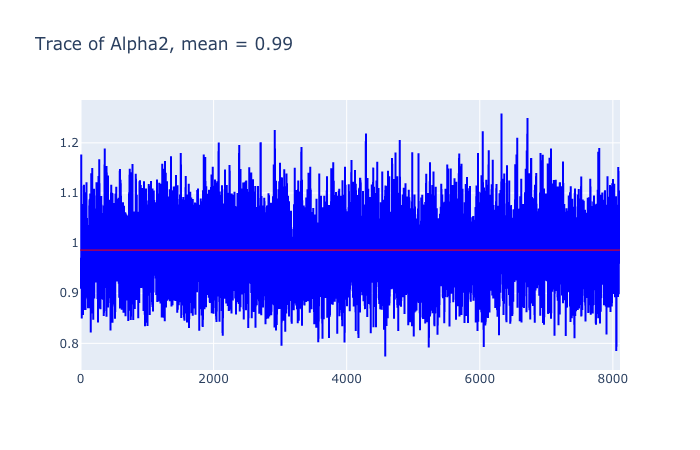

In [57]:
# Plot of Alpha2 (trace)
fig = go.Figure(
    data=[go.Scatter(y=Alpha2, marker=dict(color='blue'))],
    layout_title_text=("Trace of Alpha2, mean = {:.2f}".format(Alpha2.mean()))
    
)

hline = go.layout.Shape(type="line", x0=0, y0=Alpha2.mean(), 
                        x1=8100, y1=Alpha2.mean(),
                        line=dict(color="red", width=1, dash="solid")
                       )
                       
fig.add_shape(hline)
fig.show("png")

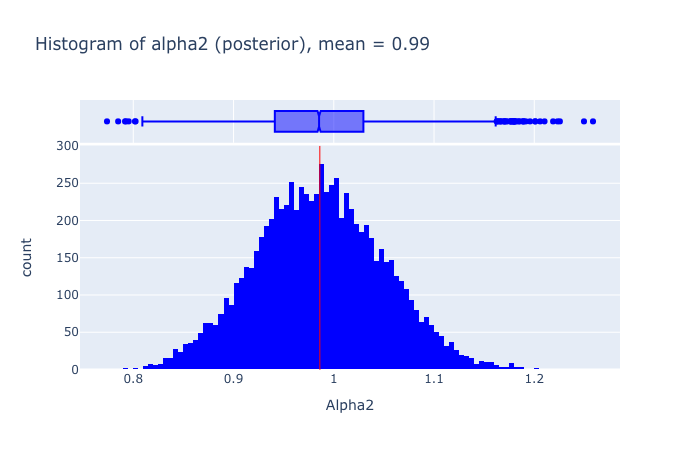

In [54]:
# Plot of Alpha2 (Distribution)
fig = px.histogram(x=Alpha2, labels={"x":"Alpha2"}, marginal='box',
                   title='Histogram of alpha2 (posterior), mean = {:.2f}'.format(Alpha2.mean()),
                   color_discrete_sequence=['blue']
                   # range_x=(0.75,0.85)
                  )

vline = go.layout.Shape(type="line", x0=Alpha2.mean(), y0=0, x1=Alpha2.mean(), y1=300, 
                        line=dict(color="red", width=1, dash="solid"))
fig.add_shape(vline)
fig.show("png")

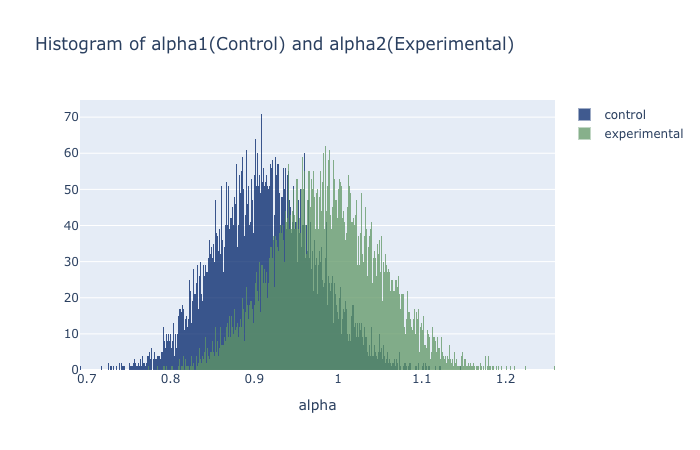

In [36]:
# Alpha1 & Alpha2
fig = go.Figure()
fig.add_trace(go.Histogram(x=Alpha1, nbinsx=500, name='control', 
                           marker=dict(
                                color="rgb(0,35,105)")
                            ))
fig.add_trace(go.Histogram(x=Alpha2, nbinsx=500, name='experimental', 
                           marker=dict(
                                color="rgb(95,150,100)")
                            ))

# Overlay both histograms
fig.update_layout(barmode='overlay', title='Histogram of alpha1(Control) and alpha2(Experimental)',
                 xaxis_title="alpha")
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show("png")

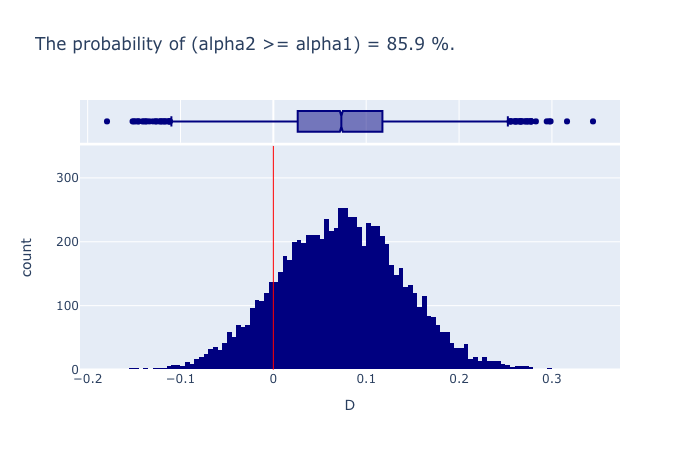

In [60]:
title = 'The probability of (alpha2 >= alpha1) = {:.1f} %.'.format(100 * np.sum(D>0)/len(D))
fig = px.histogram(x=D, labels={"x":"D"}, marginal='box', title=title, color_discrete_sequence=['navy'])
vline = go.layout.Shape(type="line", x0=0, y0=0, x1=0, y1=350, line=dict(color="red", width=1, dash="solid"))
fig.add_shape(vline)
fig.show("png")

#### Summary
* The probability of (alpha2 >= alpha1) is 85.9%, it is difficult to say the control group have positive effect.

# II. Explore the **Eight School** example 
Use the small data to explore bayesian analysis deeply